In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from collections import Counter, defaultdict, OrderedDict
import seaborn as sns
import math
import string
import sys
import random

In [1]:
# Link da apresentação:
# https://docs.google.com/presentation/d/1Nu88T4lYAQfxbOlibmbRg6QviAyX7g760gVnwpwGMoY/edit?usp=sharing

In [2]:
df_model = pd.read_csv('pre_processed_data.csv')

In [4]:
df_model.shape

(1448, 4)

### Tokenizing data

Tokenization is the process in which the sentence/text is split into array of words called tokens. This helps to do transformations on each words separately and this is also required to transform words to numbers.

In [4]:
from gensim.utils import simple_preprocess
from nltk.stem.snowball import PortugueseStemmer

Gensim’s simple_preprocess allows you to convert text to lower case and remove punctuations.

In [5]:
df_model['decisao_tokenizada'] = [simple_preprocess(line, deacc=True) for line in df_model['raw_text']] 
df_model.head()

,Unnamed: 0,id,raw_text,resultado,decisao_tokenizada
0,0,5e58e21b038d690001ceee95,PODER JUDICIÁRIOTRIBUNAL REGIONAL FEDERAL DA 3...,Favorável,"[poder, regional, federal, da, regiao, publica..."
1,1,5e58e21b038d690001ceee96,PODER JUDICIÁRIOTRIBUNAL REGIONAL FEDERAL DA 3...,Favorável,"[poder, regional, federal, da, regiao, publica..."
2,2,5e58e21b038d690001ceee97,PODER JUDICIÁRIOTRIBUNAL REGIONAL FEDERAL DA 3...,Favorável,"[poder, regional, federal, da, regiao, publica..."
3,3,5f0f8a0e96f3a30001f7bd73,ESTADO DO CEARÁ\nPODER JUDICIÁRIO\nTRIBUNAL DE...,Favorável,"[estado, do, ceara, poder, judiciario, tribuna..."
4,4,5f0f8f1947e0fd00016b3193,ESTADO DO CEARÁ\nPODER JUDICIÁRIO\nTRIBUNAL DE...,Favorável,"[estado, do, ceara, poder, judiciario, tribuna..."


### Stemming


Stemming process reduces the words to its’ root word. Unlike Lemmatization which uses grammar rules and dictionary for mapping words to root form, stemming simply removes suffixes/prefixes.

In [6]:
port_stemmer = PortugueseStemmer()
df_model['stemmed_tokens'] = [[port_stemmer.stem(word) for word in tokens] for tokens in df_model['decisao_tokenizada']]
df_model.head()

,Unnamed: 0,id,raw_text,resultado,decisao_tokenizada,stemmed_tokens
0,0,5e58e21b038d690001ceee95,PODER JUDICIÁRIOTRIBUNAL REGIONAL FEDERAL DA 3...,Favorável,"[poder, regional, federal, da, regiao, publica...","[pod, regional, federal, da, regia, public, em..."
1,1,5e58e21b038d690001ceee96,PODER JUDICIÁRIOTRIBUNAL REGIONAL FEDERAL DA 3...,Favorável,"[poder, regional, federal, da, regiao, publica...","[pod, regional, federal, da, regia, public, em..."
2,2,5e58e21b038d690001ceee97,PODER JUDICIÁRIOTRIBUNAL REGIONAL FEDERAL DA 3...,Favorável,"[poder, regional, federal, da, regiao, publica...","[pod, regional, federal, da, regia, public, em..."
3,3,5f0f8a0e96f3a30001f7bd73,ESTADO DO CEARÁ\nPODER JUDICIÁRIO\nTRIBUNAL DE...,Favorável,"[estado, do, ceara, poder, judiciario, tribuna...","[estad, do, cear, pod, judiciari, tribunal, de..."
4,4,5f0f8f1947e0fd00016b3193,ESTADO DO CEARÁ\nPODER JUDICIÁRIO\nTRIBUNAL DE...,Favorável,"[estado, do, ceara, poder, judiciario, tribuna...","[estad, do, cear, pod, judiciari, tribunal, de..."


### Building training and testing sets

In [7]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, word2vec
import time

In [10]:
df_model['resultado'].value_counts()

Desfavorável    777
Favorável       667
Name: resultado, dtype: int64

In [11]:
df_model['resultado_num'] = df_model['resultado'].map({'Desfavorável':0, 'Favorável':1})

In [12]:
df_model['resultado_num'].value_counts()

0.0    777
1.0    667
Name: resultado_num, dtype: int64

Balanceando as duas classes presentes em nosso conjunto de dados:

In [13]:
df_favs = df_model[df_model.resultado_num == 1]
df_desfavs = df_model[df_model.resultado_num == 0]

In [14]:
df_favs.shape

(667, 7)

Escolhendo aleatoriamente decisões desfavoráveis para utilizarmos:

In [15]:
ids_desfavs = list(df_desfavs.index)
ids_desfavs_dentro = random.sample(list(df_desfavs.index), 667)

In [16]:
df_desfavs_dentro = df_desfavs.loc[ids_desfavs_dentro]

Redefinindo o dataframe que utilizaremos para treinar o modelo:

In [17]:
df_model = pd.concat([df_favs, df_desfavs_dentro]).reset_index()
df_model.resultado_num.value_counts()

0.0    667
1.0    667
Name: resultado_num, dtype: int64

In [21]:
def split_train_test(df, 
                     features=['decisao_tokenizada','stemmed_tokens'],
                     target='resultado_num',
                     test_size=0.3, 
                     shuffle_state=True):
    
    X_train, X_test, Y_train, Y_test = train_test_split(df[features], 
                                                        df[target], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    
    print("Contando os valores para os resultados do conjunto de treino:")
    print(Y_train.value_counts())
    print("Contando os valores para os resultados do conjunto de teste:")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    
    return X_train, X_test, Y_train, Y_test


X_train, X_test, Y_train, Y_test = split_train_test(df_model)

Contando os valores para os resultados do conjunto de treino:
1.0    470
0.0    463
Name: resultado_num, dtype: int64
Contando os valores para os resultados do conjunto de teste:
0.0    204
1.0    197
Name: resultado_num, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [22]:
X_train

,index,decisao_tokenizada,stemmed_tokens
0,44,"[habeas, corpus, nº, rs, relator, ministro, fe...","[hab, corpus, nº, rs, relator, ministr, felix,..."
1,399,"[recurso, extraordinario, com, agravo, distrit...","[recurs, extraordinari, com, agrav, distrit, f..."
2,325,"[habeas, corpus, nº, rj, relatora, ministra, m...","[hab, corpus, nº, rj, relator, ministr, mar, t..."
3,531,"[tribunal, de, justica, do, estado, de, sao, p...","[tribunal, de, justic, do, estad, de, sao, pau..."
4,1057,"[pretende, defesa, de, carolina, dos, santos, ...","[pretend, defes, de, carolin, dos, sant, caeta..."
...,...,...,...
928,1223,"[habeas, corpus, nº, sp, relator, ministro, le...","[hab, corpus, nº, sp, relator, ministr, leopol..."
929,667,"[cuida, se, de, pedido, de, revogacao, de, pri...","[cuid, se, de, ped, de, revogaca, de, prisa, p..."
930,156,"[habeas, corpus, nº, sp, relator, ministro, re...","[hab, corpus, nº, sp, relator, ministr, reynal..."
931,384,"[habeas, corpus, nº, sp, relator, ministro, se...","[hab, corpus, nº, sp, relator, ministr, sebast..."


## Word2Vec embedding

In [26]:
size = 300
window = 3
min_count = 1
workers = 3
sg = 1

OUTPUT_FOLDER = 'output'

word2vec_file = OUTPUT_FOLDER + '/' + 'word2vec_' + str(size) + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(df_model['stemmed_tokens']).values

# treinando o Word2Vec
w2v_model = Word2Vec(stemmed_tokens, 
                     min_count = min_count, 
                     size = size, 
                     workers = workers, 
                     window = window, 
                     sg = sg)

print("Tempo para treinar o word2vec: ", str(time.time() - start_time), 'segundos')
w2v_model.save(word2vec_file)

Tempo para treinar o word2vec:  66.25003242492676 segundos


Carregando o modelo já treinado e acessando seu vocabulário:

In [27]:
sg_w2v_model = Word2Vec.load(word2vec_file)

print('Número total de palavras:',len(sg_w2v_model.wv.vocab))

vocab_size = len(sg_w2v_model.wv.vocab)

Número total de palavras: 16497


A seguir, utilizamos o modelo Word2Vec para obter os vetores de documentos no conjunto de dados:

Os vetores Word2Vec são gerados para cada decisão nos dados de treinamento, percorrendo X_train. Simplesmente usando o modelo em cada palavra da decisão, obtemos os vetores "embedding" dessas palavras. Vamos implementar a média sobre cada vetor de palavras de uma decisão e isso representará um documento de nosso conjunto de dados. Esses vetores são armazenados em um arquivo csv. O seguinte código escreve os vetores no OUTPUT_FOLDER definido na primeira etapa. 

Gerando vetores word2vec:

In [28]:
word2vec_filename = OUTPUT_FOLDER + '/' + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], 
                                axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(size))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(size)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

<ipython-input-28-eabd3448b083>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model_vector = (np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']],


In [162]:
word2vec_test = []
for index, row in X_test.iterrows():
    model_vector = np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis=0)
    word2vec_test.append(model_vector)

<ipython-input-162-b0387b130bda>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model_vector = np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis=0)


#### Definindo função de avaliação de modelos

In [135]:
from sklearn import model_selection

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

import itertools

In [136]:
# função de avaliação de modelo que roubei do Renato :)
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, 
                 i, 
                 cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_predicts_and_eval(clf, X, y_true, classes=['0', '1']):
    y_pred = clf.predict(X)
    clf_eval(X, y_true, y_pred, classes=['0','1'])
    
def clf_eval(X, y_true, y_pred, classes=['0','1']):
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred, average='weighted')))
    plot_confusion_matrix(clf_matrix, classes=classes)
    
    if len(classes) == 2:
        print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
        print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))

### Treinando o modelo de classificação usando vetores Word2Vec

#### Random Forest

In [161]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# carregando do arquivo
df_word2vec_train = pd.read_csv(word2vec_filename)

# inicializando o modelo
clf_rf_word2vec = RandomForestClassifier(criterion='entropy')

start_time = time.time()

# fitando o modelo
clf_rf_word2vec.fit(df_word2vec_train, 
                    Y_train['resultado_num'])
print("Tempo levado para fitar o modelo a partir dos vetores word2vec: " + str(time.time() - start_time))

Tempo levado para fitar o modelo a partir dos vetores word2vec: 0.9227662086486816


Classification Report
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.81       204
         1.0       0.81      0.78      0.79       197

    accuracy                           0.80       401
   macro avg       0.80      0.80      0.80       401
weighted avg       0.80      0.80      0.80       401

Accuracy Score: 0.800498753117207
f1 Score: 0.8003496639032153
Normalized confusion matrix
[[0.82352941 0.17647059]
 [0.22335025 0.77664975]]
ROC Score: 0.8000895789787996
Average Precision Score: 0.738442146989307


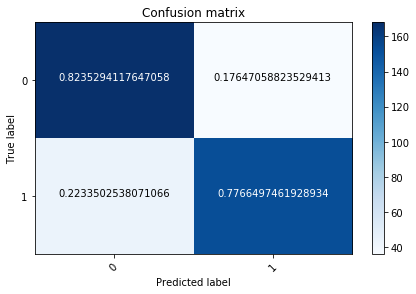

In [160]:
clf_predicts_and_eval(clf_rf_word2vec,
                     word2vec_test, 
                     Y_test['resultado_num'])

#### GaussianNB

Classification Report
              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       204
         1.0       0.76      0.69      0.72       197

    accuracy                           0.74       401
   macro avg       0.74      0.74      0.74       401
weighted avg       0.74      0.74      0.74       401

Accuracy Score: 0.7406483790523691
f1 Score: 0.7399197541058952
Normalized confusion matrix
[[0.78921569 0.21078431]
 [0.30964467 0.69035533]]
ROC Score: 0.739785508111874
Average Precision Score: 0.6766354821620764


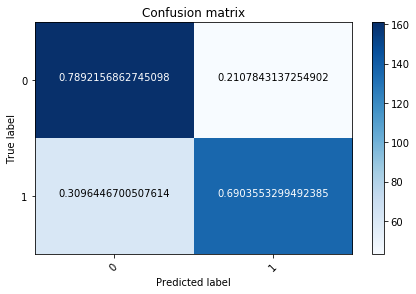

In [165]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB().fit(df_word2vec_train, Y_train['resultado_num'])

roc_gnb = clf_predicts_and_eval(clf_gnb, 
                                word2vec_test, 
                                Y_test['resultado_num'])

## Training CNN Model

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPool1D, Flatten

In [35]:
word2vec_df.shape

(933, 300)

In [140]:
import tensorflow as tf
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

X_train_kr = df_word2vec_train.astype('float32')
X_test_kr = pd.DataFrame(word2vec_test)#.astype('float32')
y_train_kr = Y_train['resultado_num'].values
y_test_kr = Y_test['resultado_num'].values

In [141]:
X_train_kr = X_train_kr.values.reshape(X_train_kr.shape[0], X_train_kr.shape[1], 1)
X_test_kr = X_test_kr.values.reshape(X_test_kr.shape[0], X_test_kr.shape[1], 1)

In [203]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(300,1)))
# mudar formato do input
model.add(Dense(16, activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(2, activation = 'sigmoid'))
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = "adam",               
              metrics = ['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 298, 64)           256       
                                                                 
 dense_26 (Dense)            (None, 298, 16)           1040      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 149, 16)          0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 2384)              0         
                                                                 
 dense_27 (Dense)            (None, 2)                 4770      
                                                                 
Total params: 6,066
Trainable params: 6,066
Non-trainable params: 0
___________________________________________________

In [193]:
history = model.fit(X_train_kr, 
                    y_train_kr, 
                    batch_size=16, 
                    epochs=200, 
                    verbose=0, 
                    validation_data=(X_test_kr, y_test_kr))

In [194]:
score = model.evaluate(X_test_kr, y_test_kr, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5804023146629333
Test accuracy: 0.7880299091339111


Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       204
         1.0       0.76      0.82      0.79       197

    accuracy                           0.79       401
   macro avg       0.79      0.79      0.79       401
weighted avg       0.79      0.79      0.79       401

Accuracy Score: 0.7880299251870324
f1 Score: 0.7878716765636441
Normalized confusion matrix
[[0.75490196 0.24509804]
 [0.17766497 0.82233503]]
ROC Score: 0.7886184930825122
Average Precision Score: 0.7156698809436518


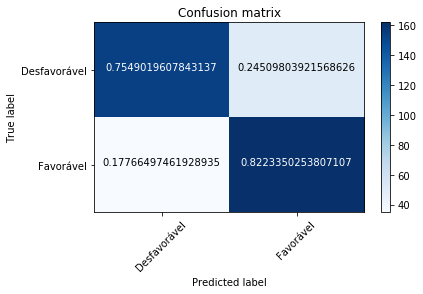

In [195]:
pred = model.predict(X_test_kr)
y_pred_kr = pred.argmax(axis=-1)

clf_eval(X_test_kr, 
         y_test_kr, 
         y_pred_kr, 
         classes = ['Desfavorável', 'Favorável'])

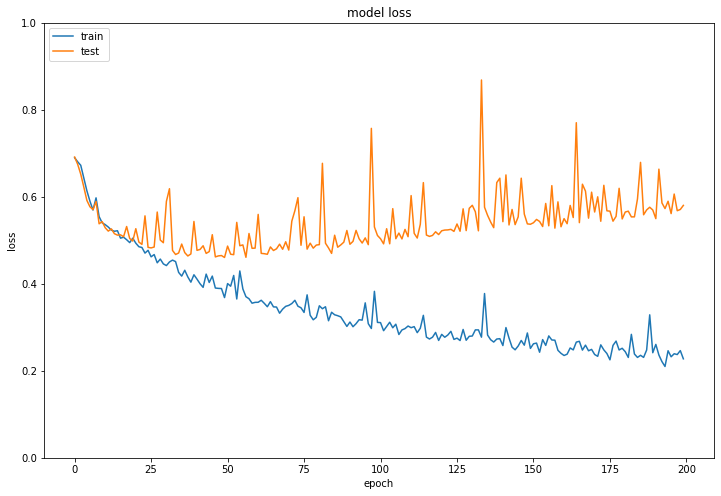

In [196]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

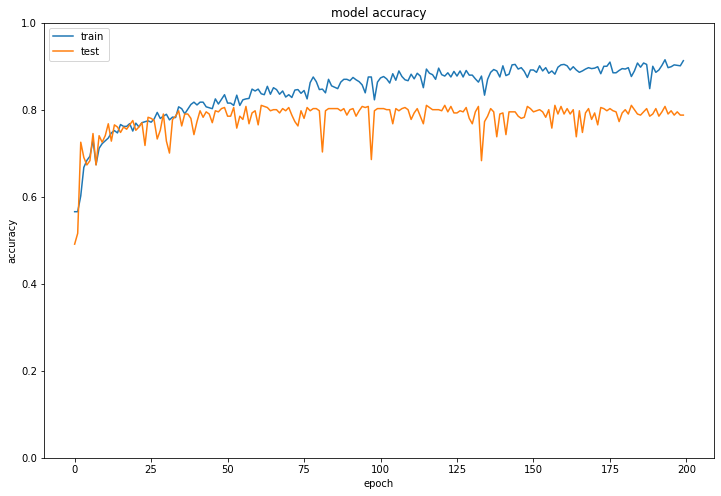

In [197]:
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Rodando novamente a rede, alterando o número de épocas:

In [198]:
min_loss = min(history.history['val_loss'])#[25]
history.history['val_loss'].index(min_loss)

49

In [199]:
history = model.fit(X_train_kr, 
                    y_train_kr, 
                    batch_size=16, 
                    epochs=49, 
                    verbose=0, 
                    validation_data=(X_test_kr, y_test_kr))

In [200]:
score = model.evaluate(X_test_kr, y_test_kr, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6192938089370728
Test accuracy: 0.7855361700057983


Classification Report
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       204
         1.0       0.82      0.73      0.77       197

    accuracy                           0.79       401
   macro avg       0.79      0.78      0.78       401
weighted avg       0.79      0.79      0.78       401

Accuracy Score: 0.7855361596009975
f1 Score: 0.7846807711903038
Normalized confusion matrix
[[0.84313725 0.15686275]
 [0.27411168 0.72588832]]
ROC Score: 0.7845127898875285
Average Precision Score: 0.7278178013993298


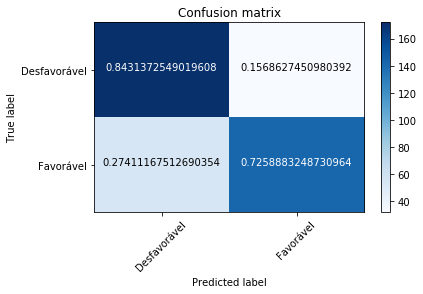

In [201]:
pred = model.predict(X_test_kr)
y_pred_kr = pred.argmax(axis=-1)

clf_eval(X_test_kr, 
         y_test_kr, 
         y_pred_kr, 
         classes = ['Desfavorável', 'Favorável'])